<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
2025-02-15 15:52:08.500378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739623928.522388  771182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739623928.529246  771182 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


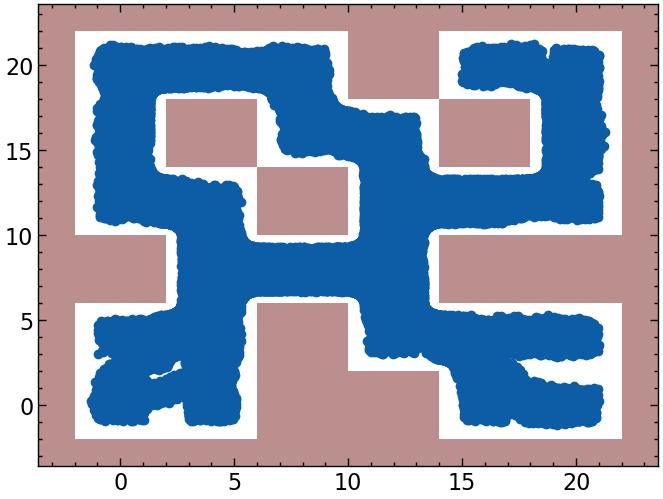

In [1]:
# MISC
import os
import sys
sys.path.append("..")

os.environ['MUJOCO_GL']='egl'
from rich.pretty import pprint
import shutup
shutup.please()

import numpy as np

# RL 
import jax
import jax.numpy as jnp
import gymnasium
import ogbench
import ogbench.online_locomotion.wrappers
import flax.linen as nn

# Custom
from envs.ogbench.ant_utils import MazeVizWrapper
from utils.datasets import Dataset, GCDataset
from agents.fb import get_config, ForwardBackwardAgent

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

# Use either exising dataset or create from data_gen_scripts
# 'pointmaze-medium-explore-v0'
# env = ogbench.make_env_and_datasets( #  train_dataset, valid_dataset 
#     "pointmaze-medium-explore-v0",
#     env_only=True, render_mode='rgb_array'
# )
env, train_dataset, valid_dataset = ogbench.make_env_and_datasets( #  train_dataset, valid_dataset 
    "pointmaze-medium-stitch-v0",
    env_only=False, render_mode='rgb_array'
)
env = MazeVizWrapper(env)
train_dataset = Dataset.create(**train_dataset)
pointmaze_explore_data = np.load("/home/m_bobrin/ZeroShotRL/aux_data/pointmaze-medium-explore-v0.npz")
fig, ax = plt.subplots()

polygons = env.draw(ax=ax)

#ax.scatter(pointmaze_explore_data['observations'][:, 0], pointmaze_explore_data['observations'][:, 1])
ax.scatter(train_dataset['observations'][:, 0], train_dataset['observations'][:, 1])

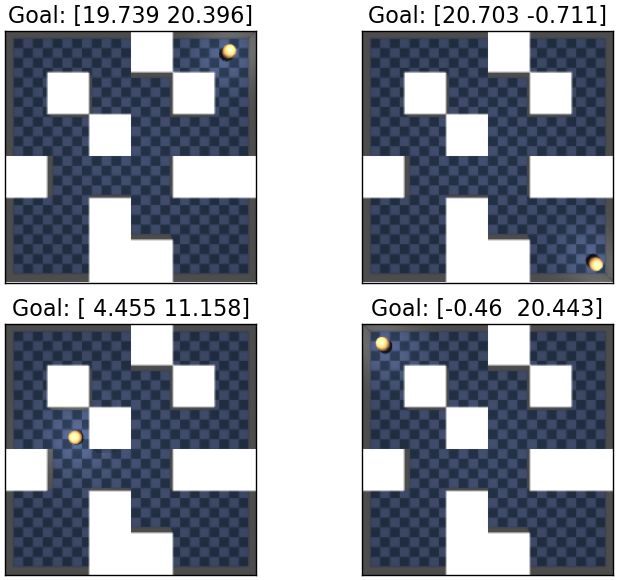

In [2]:
fig, axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()
for idx, task_id in enumerate([1, 2, 3, 4]):
    ob, info = env.reset(
        options=dict(
            task_id=task_id,
            render_goal=True,
        )
    )
    goal = info['goal']
    goal_rendered = info['goal_rendered']
    axs[idx].imshow(goal_rendered)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].set_title(f"Goal: {np.round(goal, 3)}")
plt.tight_layout()

In [2]:
fb = ForwardBackwardAgent.create(
    seed=42,
    ex_observations=train_dataset['observations'][0],
    ex_actions=train_dataset['actions'][0],
    config=get_config()
)

In [5]:
test = train_dataset['observations'][:10]
bn = nn.BatchNorm(-1, use_bias=False, momentum=0.01)
params = bn.init(GLOBAL_KEY, test)
params

{'batch_stats': {'mean': Array([0., 0.], dtype=float32),
  'var': Array([1., 1.], dtype=float32)},
 'params': {'scale': Array([1., 1.], dtype=float32)}}